In [1]:
import matplotlib
import rasterio

socio-economic conditions, such as access to schools, <br> healthcare facilities, road networks, or environmental hazards.

In [3]:
import ee
import geopandas as gpd


Successfully saved authorization token.


In [4]:
shapefile_path = '../POVERTY/district_geometries.shp'
gdf = gpd.read_file(shapefile_path)

In [10]:
gdf.columns

Index(['District', 'Year', 'ELECTHH', 'COOKFUEL', 'TOILETTYPE', 'DRINKWATER',
       'WEALTHQHH', 'WEALTHSHH', 'LATNUM', 'LONGNUM', 'pc11_d_id', 'd_name',
       'pc11_state', 'viirs_annu', 'viirs_an_1', 'viirs_an_2', 'viirs_an_3',
       'viirs_an_4', 'category', 'geometry'],
      dtype='object')

In [11]:
gdf = gdf[['District','LATNUM', 'LONGNUM', 'pc11_d_id']]

In [16]:
print(gdf)

     District     LATNUM    LONGNUM  pc11_d_id
0         585  15.353271  74.001183        585
1         586  15.284693  73.998138        586
2         491  20.618427  72.918945        491
3         483  22.747047  72.680046        483
4         489  20.777046  73.502068        489
..        ...        ...        ...        ...
516       535  17.519455  78.264648        535
517       541  17.924290  80.815651        541
518       537  17.269142  77.665649        537
519       536  17.421644  78.455246        536
520       534  18.569941  79.448517        534

[521 rows x 4 columns]


In [17]:
gdf.to_csv('district_coordinates_2015_corrected.csv', index=False, encoding='utf-8')

## GEE Console code


// Load the FeatureCollection of district coordinates.
var districtCoordinates = ee.FeatureCollection('projects/scenic-lane-400211/assets/top_100_district_coordinates_2015_');

// Function to create a 10km x 10km square buffer around each point (district's coordinates).
function createBoundingBox(feature) {
  var lat = feature.get('LATNUM');
  var lon = feature.get('LONGNUM');
  var point = ee.Geometry.Point([lon, lat]);
  var square = point.buffer(10000 / 2 * Math.sqrt(2)).bounds();
  return feature.setGeometry(square);
}

// Apply the function to all districts to create their bounding boxes.
var districtBoundingBoxes = districtCoordinates.map(createBoundingBox);

// Sentinel-2 composite image for the specified time range.
var sentinel2Composite = ee.ImageCollection('COPERNICUS/S2')
                            .filterDate('2015-01-01', '2015-12-31')
                            .filterBounds(districtBoundingBoxes)
                            .median();

// Function to set up export tasks for each district
function setupExport(districtFeature, index) {
  var districtImage = sentinel2Composite.clip(districtFeature.geometry());

  // Use district ID for naming, ensure it's fetched correctly before this point
  var districtId = districtFeature.get('District').getInfo(); // This should be adjusted

  Export.image.toDrive({
    image: districtImage,
    description: 'DistrictImage_' + districtId,
    folder: 'GEE_District_Images',
    scale: 10,
    region: districtFeature.geometry().bounds(),
    maxPixels: 1e13
  });
}

function visualizeDistrictImage(districtFeature) {
  var districtImage = sentinel2Composite.clip(districtFeature.geometry());
  
  // Generate a unique name for the layer based on the district ID
  var districtId = districtFeature.get('District').getInfo(); // This is synchronous and should be used cautiously
  
  // Add the clipped district image to the map
  Map.addLayer(districtImage, {bands: ['B4', 'B3', 'B2'], max: 3000}, 'District Image ' + districtId);
}

// Manual iteration for batch processing
// Here, you manually update 'batchStart' for subsequent batches
var batchSize = 10; // Define the size of each batch
var batchStart = 0; // Update this manually for each batch

// Select a batch of districts based on 'batchStart' and 'batchSize'
var batchDistricts = districtBoundingBoxes.toList(batchSize, batchStart);

// Manually initiate export for each district in the batch
for (var i = 0; i < batchSize; i++) {
  var districtFeature = ee.Feature(batchDistricts.get(i));
  setupExport(districtFeature, batchStart + i); // Pass the correct index or ID
}

In [29]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Replace 'path/to/your/image.tif' with your actual file path
with rasterio.open('./DistrictImage_363.tif') as src:
    image = src.read(1)  # Assuming band 1 contains the data you want to visualize


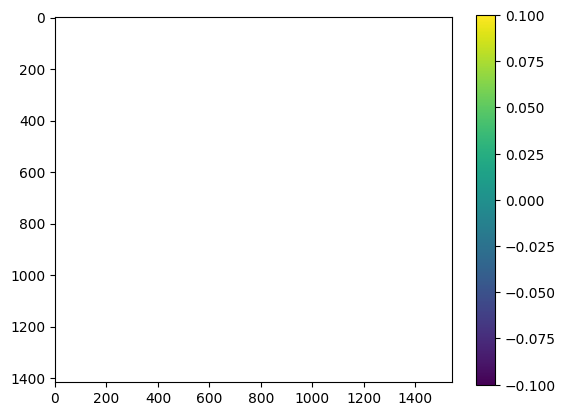

In [30]:
plt.imshow(image)
plt.colorbar()
plt.show()
